## CNN For Brand Logo Detection - Arc'teryx

In [13]:
import torch
from torch.utils.data import DataLoader, random_split,Dataset
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os

In [3]:
# Loading and performing transformations on the image data 
class LogoDataset(Dataset):
    def __init__(self, arcteryx_dir, not_arcteryx_dir, transform=None):
        self.arcteryx_images = [os.path.join(arcteryx_dir, f) for f in os.listdir(arcteryx_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.not_arcteryx_images = [os.path.join(not_arcteryx_dir, f) for f in os.listdir(not_arcteryx_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.all_images = self.arcteryx_images + self.not_arcteryx_images
        self.labels = [1] * len(self.arcteryx_images) + [0] * len(self.not_arcteryx_images)
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        image_path = self.all_images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# File Path for the images
arcteryx_dir = "C:/Users/vinay/Downloads/arcteryx"
not_arcteryx_dir = "C:/Users/vinay/Downloads/not_arcteryx"

In [5]:
# Create the dataset
full_dataset = LogoDataset(arcteryx_dir, not_arcteryx_dir, transform=transform)


In [6]:
# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [7]:
# Initialize the dataloaders    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
#Defining a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)  # Flatten the tensor
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Linear-7                  [-1, 512]       8,389,120
           Dropout-8                  [-1, 512]               0
            Linear-9                    [-1, 2]           1,026
Total params: 8,413,730
Trainable params: 8,413,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 4.38
Params size (MB): 32.10
Estimated Total Size (MB): 36.67
-------------------------------------

In [ ]:
# Function for training
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            # Clear the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Print loss statistics
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Validation Accuracy: {val_accuracy}%")
    
    print('Finished Training')

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=25)

Epoch 1, Loss: 0.9375314286776951, Validation Accuracy: 76.08695652173913%
Epoch 2, Loss: 0.5359691636902946, Validation Accuracy: 78.26086956521739%
Epoch 3, Loss: 0.5315776893070766, Validation Accuracy: 78.26086956521739%
Epoch 4, Loss: 0.4693925210407802, Validation Accuracy: 80.43478260869566%
Epoch 5, Loss: 0.45927501576287405, Validation Accuracy: 80.43478260869566%
Epoch 6, Loss: 0.3930000492504665, Validation Accuracy: 80.43478260869566%
Epoch 7, Loss: 0.3109604993036815, Validation Accuracy: 84.78260869565217%
Epoch 8, Loss: 0.2911819964647293, Validation Accuracy: 86.95652173913044%
Epoch 9, Loss: 0.2145502269268036, Validation Accuracy: 86.95652173913044%
Epoch 10, Loss: 0.1783089286514691, Validation Accuracy: 84.78260869565217%
Epoch 11, Loss: 0.1549925718988691, Validation Accuracy: 89.1304347826087%
Epoch 12, Loss: 0.10405803897551127, Validation Accuracy: 86.95652173913044%
Epoch 13, Loss: 0.0943068473466805, Validation Accuracy: 86.95652173913044%
Epoch 14, Loss: 0.05

In [ ]:
# Function to display images and their labels
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Function to visualize model predictions
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

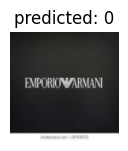

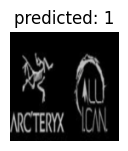

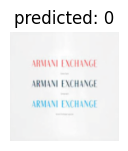

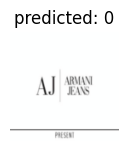

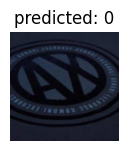

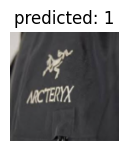

In [ ]:
visualize_model(model, num_images=6)
plt.ioff()
plt.show()

## Customer Lifetime Value MODEL

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
#Pulling the input data
train=pd.read_csv('C:/Users/vinay/Downloads/train_BRCpofr.csv')


In [ ]:
# Split data into X and y
X = train.drop(columns=['id', 'cltv'])
y = train['cltv']

In [ ]:
# Split the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [ ]:
#Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [ ]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(
    iterations=1000, 
    learning_rate=0.1, 
    depth=6,
    cat_features=['gender', 'area', 'qualification', 'income', 'marital_status', 'num_policies', 'policy', 'type_of_policy'],
    loss_function='RMSE'
)

In [ ]:
# Train the model
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=100,
    early_stopping_rounds=100
)


0:	learn: 89245.6001446	test: 90967.9893978	best: 90967.9893978 (0)	total: 63.5ms	remaining: 1m 3s
100:	learn: 82649.6900740	test: 84681.0794558	best: 84681.0794558 (100)	total: 5.58s	remaining: 49.7s
200:	learn: 82382.3137606	test: 84674.0116028	best: 84674.0116028 (200)	total: 11.2s	remaining: 44.5s
300:	learn: 82149.5301541	test: 84670.5825546	best: 84668.3708491 (233)	total: 17.4s	remaining: 40.3s
400:	learn: 81889.3768347	test: 84659.7229090	best: 84655.9583498 (390)	total: 23.4s	remaining: 35s
500:	learn: 81646.6574105	test: 84679.6510927	best: 84654.3079114 (449)	total: 29.7s	remaining: 29.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 84654.30791
bestIteration = 449

Shrink model to first 450 iterations.


In [ ]:
# Predict on validation set
predictions = model.predict(X_val)

# Calculate RMSE
rmse = mean_squared_error(y_val, predictions, squared=False)
print(f'Validation RMSE: {rmse}')


Validation RMSE: 84654.30791136625


In [ ]:
# Predict on validation set
predictions = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Test RMSE: {rmse}')


Test RMSE: 82116.4512478656
